In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler
import pickle
import os
import glob
import seaborn as sns

In [279]:
data = pd.read_csv(r'data/joined_hold_times_data_all.csv', index_col=0)
#data = data[data.notna().all(axis=1)]

In [280]:
def member_train_test_split(df, test_size = 0.25):
    """
    Creates train and test sets per member based on test_size
    assumes rows are in time order so does not shuffle
    """
    train_size = (1 - test_size)
    g = df.groupby('member')
    train_flags = (g.cumcount() + 1) <= g.transform('size') * train_size
    test_flags = (g.cumcount() + 1) > g.transform('size') * train_size
    
    # Split X and y (hold_time)
    X_train = df[train_flags].drop('hold_time', axis=1)
    X_test = df[test_flags].drop('hold_time', axis=1)
    y_train = df[train_flags].hold_time
    y_test = df[test_flags].hold_time
    
    return X_train, X_test, y_train, y_test

In [281]:
# Split train/test
X_train, X_test, y_train, y_test = member_train_test_split(data)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(13132, 9) (13132,) (4703, 9) (4703,)


In [282]:
"""
Replaced with order based split to account for time
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop('hold_time', axis=1), data['hold_time'], random_state = 123)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
"""

"\nReplaced with order based split to account for time\n# Split train/test\nX_train, X_test, y_train, y_test = train_test_split(data.drop('hold_time', axis=1), data['hold_time'], random_state = 123)\nprint(X_train.shape, y_train.shape, X_test.shape, y_test.shape)\n"

In [283]:
# Dropping difficulty as difficulty should be encoded by splitting piece counts up by difficulty
X_train = X_train.drop(['diff_0', 'diff_1'], axis=1)
X_test = X_test.drop(['diff_0', 'diff_1'], axis=1)

In [284]:
print(len(X_train))
print(len(X_train[X_train.isna().any(axis=1)]))
print(len(X_train[X_train.notna().all(axis=1)]))

13132
1094
12038


In [285]:
print(len(X_test))
print(len(X_test[X_test.isna().any(axis=1)]))
print(len(X_test[X_test.notna().all(axis=1)]))

4703
298
4405


In [286]:
# Handle puzzles with no info, this is quite common
# Drop them from training as to not introduce non-existant signal
y_train = y_train[X_train.notna().all(axis=1)]
X_train = X_train[X_train.notna().all(axis=1)]

# Can't drop from test as we still need to predict something for these people
# Try filling with median?
X_test_not_missing = X_test.notna().all(axis=1)
X_test['pieces_d1'] = X_test.pieces_d1.fillna(X_train.pieces_d1.mean())
X_test['pieces_d2'] = X_test.pieces_d2.fillna(X_train.pieces_d2.mean())
X_test['pieces_d3'] = X_test.pieces_d3.fillna(X_train.pieces_d3.mean())
X_test['pieces_d4'] = X_test.pieces_d4.fillna(X_train.pieces_d4.mean())
X_test.num_puzzles = X_test.num_puzzles.fillna(2) # just doing this manually as basically every pack has 2 puzzles

In [287]:
# Calculate global distribution info for each puzzle
full_training_set = X_train.copy()
full_training_set['hold_time'] = y_train.copy()
hold_summary_by_pack = full_training_set.groupby(by=['pack_name'])['hold_time'].describe()

# Some packs only have 1 data point so std dev is NaN, fill with avg std dev from the entire set
hold_summary_by_pack['std'] = hold_summary_by_pack['std'].fillna(hold_summary_by_pack['std'].mean())

# There are likely going to be instances in the test set where we don't have data for a pack, use the global averages for now
# TODO come up with a more sophisticated way to handle packs we don't have data for

In [288]:
X_test[X_test.isna().any(axis=1)]

,member,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles


In [289]:
# Join the training data with the per pack info, just going to use mean and std for now
# TODO try out other variations on pack hold-time distribution information
X_train = pd.merge(X_train, hold_summary_by_pack[['count','std', 'mean']], left_on='pack_name', right_index=True, how='left')
X_train['pack_hold_time_std'] = X_train['std']
X_train['pack_hold_time_mean'] = X_train['mean']
X_train['pack_hold_time_count'] = X_train['count']
X_train = X_train.drop(['std', 'mean', 'count'], axis=1)



In [290]:
X_train[X_train.isna().any(axis=1)]

,member,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles,pack_hold_time_std,pack_hold_time_mean,pack_hold_time_count


In [291]:
# Add pack hold_time avg and std dev from training set to test set data
X_test = pd.merge(X_test, hold_summary_by_pack[['count', 'std', 'mean']], left_on='pack_name', right_index=True, how='left')
X_test['pack_hold_time_std'] = X_test['std']
X_test['pack_hold_time_mean'] = X_test['mean']
X_test['pack_hold_time_count'] = X_test['count']
X_test = X_test.drop(['mean', 'std', 'count'], axis=1)

# For packs from the test set with pack hold time data, fill with the means from the hold_time summary created using only training data
X_test['pack_hold_time_mean'] = X_test['pack_hold_time_mean'].fillna(hold_summary_by_pack['mean'].mean())
X_test['pack_hold_time_std'] = X_test['pack_hold_time_std'].fillna(hold_summary_by_pack['std'].mean())
X_test['pack_hold_time_count'] = X_test['pack_hold_time_count'].fillna(hold_summary_by_pack['count'].mean())

In [292]:
# Similar hold time distribution info per member, if hold-time data not present use global avg
hold_summary_by_member = full_training_set.groupby(by='member')['hold_time'].describe()
X_train = pd.merge(X_train, hold_summary_by_member[['count', 'mean', 'std']].rename(columns={'count': 'member_hold_time_count', 'mean': 'member_hold_time_mean', 'std': 'member_hold_time_std'}), left_on='member', right_index=True, how='left')
X_test = pd.merge(X_test, hold_summary_by_member[['count', 'mean', 'std']].rename(columns={'count': 'member_hold_time_count', 'mean': 'member_hold_time_mean', 'std': 'member_hold_time_std'}), left_on='member', right_index=True, how='left')

# For missing hold time summary data impute with global avg of the training set
#Filling train
X_train['member_hold_time_mean'] = X_train['member_hold_time_mean'].fillna(hold_summary_by_member['mean'].mean())
X_train['member_hold_time_std'] = X_train['member_hold_time_std'].fillna(hold_summary_by_member['std'].mean())
X_train['member_hold_time_count'] = X_train['member_hold_time_count'].fillna(hold_summary_by_member['count'].mean())
# Filling test
X_test['member_hold_time_mean'] = X_test['member_hold_time_mean'].fillna(hold_summary_by_member['mean'].mean())
X_test['member_hold_time_std'] = X_test['member_hold_time_std'].fillna(hold_summary_by_member['std'].mean())
X_test['member_hold_time_count'] = X_test['member_hold_time_count'].fillna(hold_summary_by_member['count'].mean())


array([[<AxesSubplot: title={'center': 'mean'}>]], dtype=object)

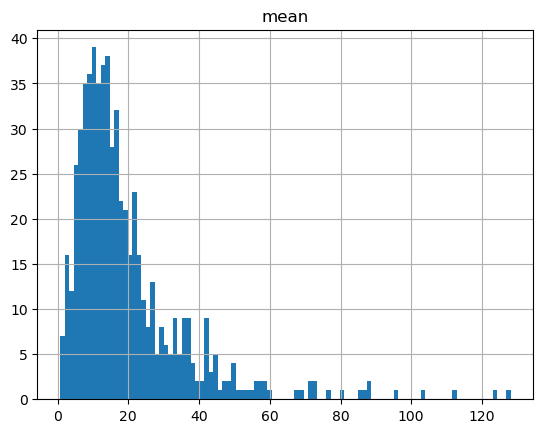

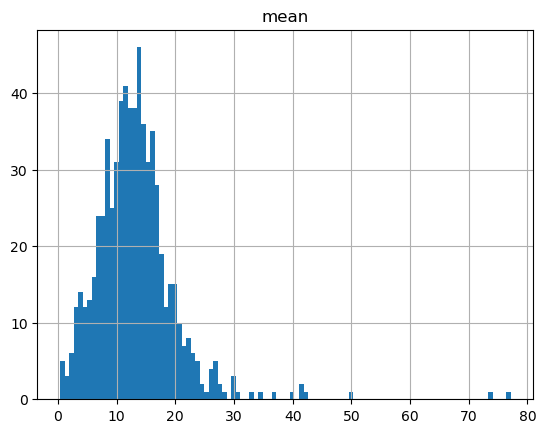

In [293]:
hold_summary_by_member.hist('mean', bins=100)
hold_summary_by_pack.hist('mean', bins=100)

/var/folders/vs/2pyq73711mgf5lg0y3w7rllm0000gn/T/ipykernel_9105/2997534890.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sns.heatmap(X_train_numeric.corr(), cmap="YlGnBu", annot=True)


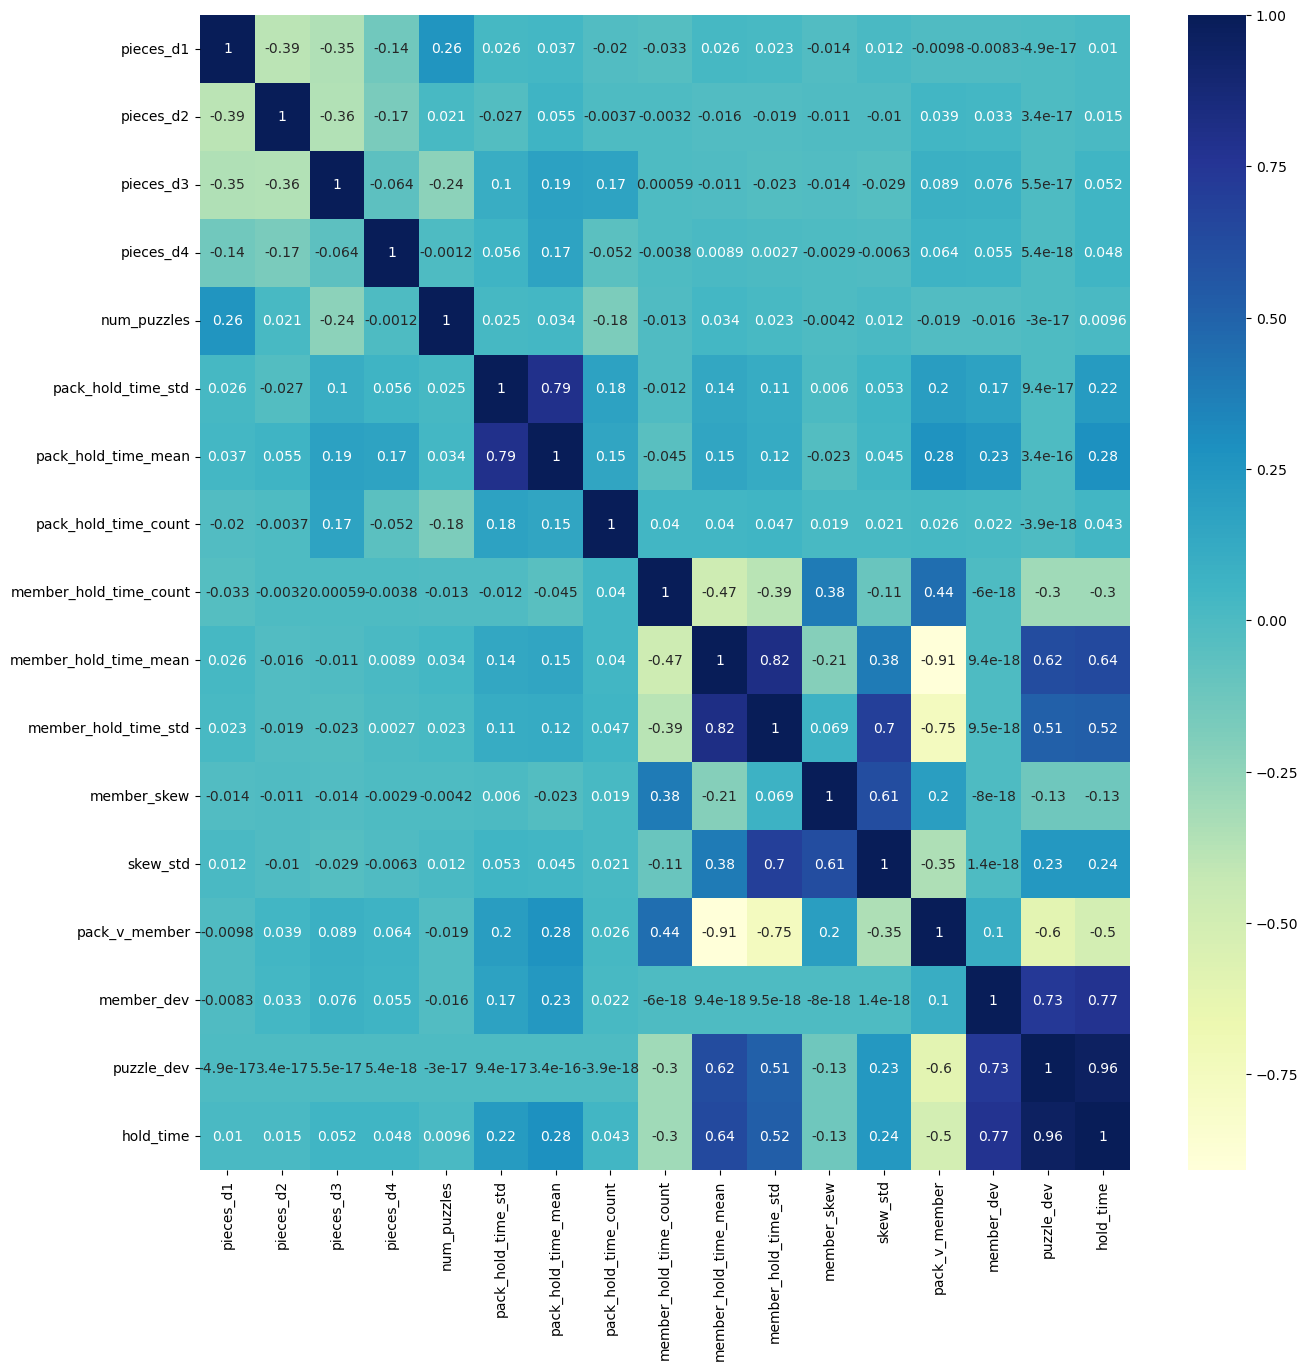

In [294]:
# plotting correlation heatmap
X_train_numeric = pd.merge(X_train, full_training_set.groupby(by='member')['hold_time'].skew(), left_on='member', right_index=True, how='left')
X_train_numeric = X_train_numeric.drop(['member'], axis=1)
X_train_numeric = X_train_numeric.rename({'hold_time': 'member_skew'}, axis=1)
X_train_numeric['skew_std'] = X_train_numeric['member_skew'] * X_train_numeric.member_hold_time_std
X_train_numeric['skew_std'] = X_train_numeric['member_skew'] * X_train_numeric.member_hold_time_std
X_train_numeric['pack_v_member'] = X_train_numeric.pack_hold_time_mean - X_train_numeric.member_hold_time_mean
X_train_numeric['member_dev'] = (y_train - X_train_numeric['member_hold_time_mean'])
X_train_numeric['puzzle_dev'] = (y_train - X_train_numeric['pack_hold_time_mean'])
X_train_numeric['hold_time'] = y_train
plt.figure(figsize=(15,15))
dataplot = sns.heatmap(X_train_numeric.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

<AxesSubplot: >

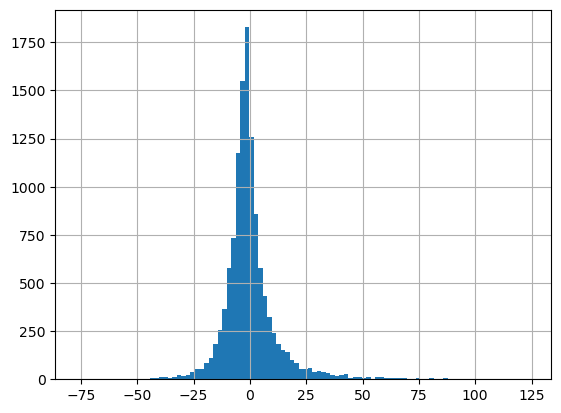

In [295]:
X_train_numeric.member_dev.hist(bins=100)

<AxesSubplot: xlabel='member_skew', ylabel='member_dev'>

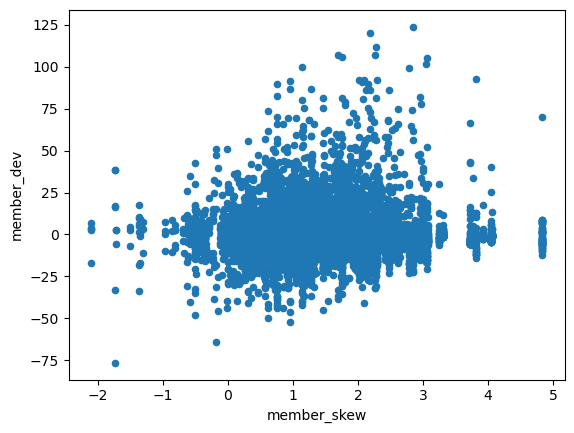

In [296]:
X_train_numeric.plot(x='member_skew', y='member_dev', kind='scatter')

In [297]:
# Dropping some things to see
#X_train = X_train.drop(['member_hold_time_mean', 'member_hold_time_std', 'member_hold_time_count', 'pack_hold_time_count'], axis=1)
#X_test = X_test.drop(['member_hold_time_mean', 'member_hold_time_std', 'member_hold_time_count', 'pack_hold_time_count'], axis=1)

X_train = X_train.drop(['pack_hold_time_mean', 'pack_hold_time_std', 'pack_hold_time_count', 'num_puzzles'], axis=1)
X_test = X_test.drop(['pack_hold_time_mean', 'pack_hold_time_std', 'pack_hold_time_count', 'num_puzzles'], axis=1)

In [298]:
record_counts = X_train.member.value_counts()
record_counts

member557    132
member474    106
member40      87
member414     85
member292     85
            ... 
member13       1
member642      1
member645      1
member649      1
member520      1
Name: member, Length: 619, dtype: int64

In [299]:
MAX_STD = 5000
MIN_HISTORY = 75 # Minimum number of data points for a member to get their own model
# 3.6 / 13.2 @ 100
# 3.5 / 12.9 @ 75
# 5.5 / 14.2 @ 50
# 8.5 / 17.2 @ 25
# 11.6 / 22.3 @ 10

In [300]:
# Fit Scaler on all training data
# TODO Try out other scaler
scaler = StandardScaler()
scaler = scaler.fit(X_train.drop(['member', 'pack_name'], axis=1))

In [301]:
def train_linear_regression(X, y, scaler):
    '''
    Trains linear regression model using the given X, y, and scaler
    
    Returns the trained model
    '''
    
    lr = linear_model.LinearRegression()
    
    # Scale X
    X_s = scaler.transform(X)
    #X_s = X.to_numpy()
    # Fit linear regression model
    lr.fit(X_s, y)
    
    return lr

In [302]:
# For each member with more than MIN_HISTORY data points, train a linear regression model for them and save
# Filter to members with more than MIN_HISTORY points
members = record_counts[(record_counts >= MIN_HISTORY)]
for member, c in members.items():
    # Require a max std in hold, only learn for people who seem stable
    member_std = hold_summary_by_member.loc[member]
    if member_std['std'] > MAX_STD:
        continue
        
    X_train_m = X_train[X_train['member'] == member]
    y_train_m = y_train[X_train['member'] == member]
    
    m = train_linear_regression(X_train_m.drop(['member', 'pack_name'], axis=1), y_train_m, scaler)
    
    # Save model for later use
    with open(f'user_models/{member}.pkl', 'wb') as f:
        pickle.dump(m, f)

In [303]:
# Create a overall model on all data points for use on users without MIN_HISTORY data points
overall_m = train_linear_regression(X_train.drop(['member', 'pack_name'], axis=1), y_train, scaler)
with open(f'user_models/universal.pkl', 'wb') as f:
    pickle.dump(overall_m, f)

In [304]:
# Create model just on users with less than MIN_HISTORY data points as a "new puzzler" model
newps = record_counts[record_counts < MIN_HISTORY].index
X_train_newps = X_train[X_train['member'].isin(newps)]
y_train_newps = y_train[X_train['member'].isin(newps)]
newps_m = train_linear_regression(X_train_newps.drop(['member', 'pack_name'], axis=1), y_train_newps, scaler)
with open(f'user_models/newps.pkl', 'wb') as f:
    pickle.dump(newps_m, f)

In [305]:
def make_pred(X, member, default):
    '''
    args:
        - X - scaled input data
        - member - member string
        - default - default model to use
        
    Look up the proper model and use it, if not use default model
    
    Returns the (predicted hold time, the model used)
    '''
    
    # Check if trained model for member exists
    path = f'user_models/{member}.pkl'

    if os.path.exists(path):
        m = pickle.load(open(path, 'rb'))
        
        return (m.predict(X), member)
        
    else:
        # Use default model
        return (default.predict(X), "default")

In [306]:
# Go through test set and either use the per user model or the universal model
univ_model = pickle.load(open('user_models/universal.pkl', 'rb'))
newps_model = pickle.load(open('user_models/newps.pkl', 'rb'))
print(X_train.drop(['member', 'pack_name'], axis=1).columns)
print(f"Universal Coef {univ_model.coef_}")
print(f"Newps Coef {newps_model.coef_}")
# Scale test data using scaler fit on the training data

X_test_members = X_test['member']
X_test_packs = X_test['pack_name']
X_test_scaled = scaler.transform(X_test.drop(['member', 'pack_name'], axis=1))
#X_test_scaled = X_test.drop(['member', 'pack_name'], axis=1).to_numpy()

Index(['pieces_d1', 'pieces_d2', 'pieces_d3', 'pieces_d4',
       'member_hold_time_count', 'member_hold_time_mean',
       'member_hold_time_std'],
      dtype='object')
Universal Coef [ 1.96268797  2.39112375  2.62206506  1.53420493  0.1002531  10.32316364
  0.17189966]
Newps Coef [ 2.03889872  2.4608197   2.69484494  1.56316826  0.13466524 10.33005481
  0.1730354 ]


In [307]:
y_pred_universal, y_pred_universal_models = zip(*[make_pred(x.reshape(1, -1), m, univ_model) for x, m in zip(X_test_scaled, X_test_members)])
y_pred_universal = np.array(list(y_pred_universal))
y_pred_universal_models = np.array(list(y_pred_universal_models))
mse_univ = mean_squared_error(y_test, y_pred_universal)
mae_univ = mean_absolute_error(y_test, y_pred_universal)
print(f'Using universal default combined mse: {mse_univ}, mae: {mae_univ}')

mse_univ_usermodel = mean_squared_error(y_test[y_pred_universal_models != "default"], y_pred_universal[y_pred_universal_models != "default"])
mae_univ_usermodel = mean_absolute_error(y_test[y_pred_universal_models != "default"], y_pred_universal[y_pred_universal_models != "default"])
print(f'Using universal, user mse: {mse_univ_usermodel}, mae: {mae_univ_usermodel}')

mse_univ_default = mean_squared_error(y_test[y_pred_universal_models == "default"], y_pred_universal[y_pred_universal_models == "default"])
mae_univ_default = mean_absolute_error(y_test[y_pred_universal_models == "default"], y_pred_universal[y_pred_universal_models == "default"])
print(f'Using universal, default mse: {mse_univ_default}, mae: {mae_univ_default}')

Using universal default combined mse: 522.1756476380621, mae: 13.0212957291373
Using universal, user mse: 62.98943021215402, mae: 4.625958495474126
Using universal, default mse: 560.4676104826092, mae: 13.721390656247658


In [308]:
y_pred_newps, y_pred_newps_models = zip(*[make_pred(x.reshape(1, -1 ), m, newps_model) for x, m in zip(X_test_scaled, X_test_members)])
y_pred_newps = np.array(list(y_pred_newps))
y_pred_newps_models = np.array(list(y_pred_newps_models))
mse_newps = mean_squared_error(y_test, y_pred_newps)
mae_newps = mean_absolute_error(y_test, y_pred_newps)
print(f'Using newps combined mse: {mse_newps}, mae: {mae_newps}')

mse_newps_usermodel = mean_squared_error(y_test[y_pred_newps_models != "default"], y_pred_newps[y_pred_newps_models != "default"])
mae_newps_usermodel = mean_absolute_error(y_test[y_pred_newps_models != "default"], y_pred_newps[y_pred_newps_models != "default"])
print(f'Using newps, user mse: {mse_newps_usermodel}, mae: {mae_newps_usermodel}')

mse_newps_default = mean_squared_error(y_test[y_pred_newps_models == "default"], y_pred_newps[y_pred_newps_models == "default"])
mae_newps_default = mean_absolute_error(y_test[y_pred_newps_models == "default"], y_pred_newps[y_pred_newps_models == "default"])
print(f'Using newps, default mse: {mse_newps_default}, mae: {mae_newps_default}')


Using newps combined mse: 522.0700482259101, mae: 13.021581398932065
Using newps, user mse: 62.98943021215402, mae: 4.625958495474126
Using newps, default mse: 560.3532050379303, mae: 13.721700148310497


In [309]:
set(y_pred_universal_models[y_pred_universal_models != "default"])

{'member117',
 'member279',
 'member292',
 'member324',
 'member363',
 'member40',
 'member402',
 'member414',
 'member474',
 'member557',
 'member608'}

In [310]:
print(len(y_test))
print(len(y_test[y_pred_newps_models != "default"]))
print(len(y_test[(y_pred_newps_models != "default") & (X_test_not_missing)]))
mean_absolute_error(y_test[(y_pred_newps_models != "default") & (X_test_not_missing)], y_pred_newps[(y_pred_newps_models != "default") & (X_test_not_missing)])

4703
362
340


4.59828444364085

In [311]:
file = glob.glob('user_models/*')
for f in file:
    os.remove(f)
    pass

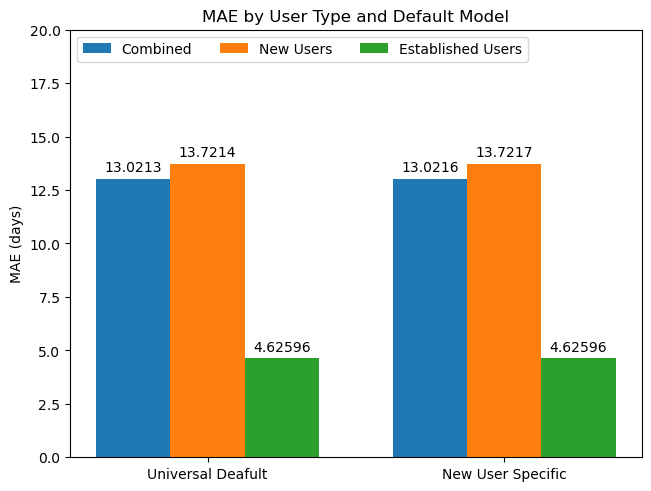

In [312]:
approaches = ("Universal Deafult", "New User Specific")
model_mae = {
    "Combined": (mae_univ, mae_newps),
    "New Users": (mae_univ_default, mae_newps_default),
    "Established Users": (mae_univ_usermodel, mae_newps_usermodel)
}

x = np.arange(len(approaches))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for model, mae in model_mae.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, mae, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAE (days)')
ax.set_title('MAE by User Type and Default Model')
ax.set_xticks(x + width, approaches)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 20)

plt.show()